In [1]:
import pandas as pd

# Dataset
https://www.kaggle.com/datasets/yacharki/yelp-reviews-for-sa-finegrained-5-classes-csv

In [2]:
df = pd.read_csv("./yelp_review_fine-grained_5_classes_csv/train.csv")
df.head(), len(df)

(   class_index                                        review_text
 0            5  dr. goldberg offers everything i look for in a...
 1            2  Unfortunately, the frustration of being Dr. Go...
 2            4  Been going to Dr. Goldberg for over 10 years. ...
 3            4  Got a letter in the mail last week that said D...
 4            1  I don't know what Dr. Goldberg was like before...,
 650000)

In [3]:
df = df[df.review_text.apply(lambda x: len(str(x)) <= 85 and len(str(x)) >= 2)]
len(df)

21394

In [4]:
df["review_text"] = df["review_text"].str.lower()
df["review_text"] = df["review_text"].str.strip()

In [5]:
df.dropna(how='all', axis=1, inplace=True)
len(df)

21394

In [6]:
df_train = df.sample(frac=0.98, random_state=42)
df_test_model = df.drop(df_train.index)

In [7]:
import numpy as np

In [8]:
SEQ_LEN = np.max([len(str(rew)) for rew in df_train["review_text"]])
SEQ_LEN

85

In [9]:
x_train = df_train["review_text"]
y_train = df_train["class_index"].values.astype(int)

In [10]:
from transformers import AutoTokenizer

In [11]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [12]:
Xids =  np.zeros((len(df_train),SEQ_LEN))
Xmask = np.zeros((len(df_train),SEQ_LEN))

In [13]:
for i, sequence in enumerate(df_train["review_text"]):
    tokens = tokenizer.encode_plus(str(sequence), max_length=SEQ_LEN, truncation=True, padding="max_length", add_special_tokens=True, return_token_type_ids="tf")

    Xids[i, :], Xmask[i, :] = tokens["input_ids"], tokens["attention_mask"]

In [14]:
y_train

array([5, 3, 2, ..., 4, 4, 4])

In [15]:
labels = np.zeros((y_train.size, y_train.max()))
labels.shape

(20966, 5)

In [16]:
labels[np.arange(y_train.size), y_train-1] = 1
labels

array([[0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

In [17]:
import tensorflow as tf

2024-06-20 20:49:50.310380: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-20 20:49:50.947830: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-20 20:49:52.164799: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [18]:
tf.config.list_physical_devices('GPU')

2024-06-20 20:49:55.601628: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-20 20:49:55.873162: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-20 20:49:55.873316: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [19]:
from transformers import TFAutoModel

In [20]:
bert = TFAutoModel.from_pretrained('bert-base-uncased')

2024-06-20 20:50:02.986774: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-20 20:50:02.986838: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-20 20:50:02.986855: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-20 20:50:04.267329: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-20 20:50:04.267378: I external/local_xla/xla/stream_executor

In [21]:
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), name="input_ids", dtype="int32")
mask = tf.keras.layers.Input(shape=(SEQ_LEN,), name="attention_mask", dtype="int32")

embeddings = bert(input_ids, attention_mask=mask)[0]

X = tf.keras.layers.GlobalMaxPooling1D()(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(256, activation="relu")(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(32, activation="relu")(X)
y = tf.keras.layers.Dense(5, activation="softmax", name="outputs")(X)

model = tf.keras.Model(inputs=[input_ids, mask], outputs = y)

model.layers[2].trainable = False

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 85)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 85)]                 0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 85, 76                                       

In [23]:
optimizer = tf.keras.optimizers.Adam(0.001)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy("accuracy")

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

If you have saved the weights of the model, below is the place to load the weights and skip training

In [25]:
#model.load_weights('./model.hdf5')

In [24]:
len(Xids), len(Xmask), len(labels)

(20966, 20966, 20966)

In [25]:
Xids = np.array(Xids)

In [26]:
Xmask = np.array(Xmask)

In [27]:
history = model.fit([Xids, Xmask], labels, validation_split=0.2, epochs=135, batch_size=64)

Epoch 1/135


I0000 00:00:1718684278.551837    2044 service.cc:145] XLA service 0x7f78b49448d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718684278.551899    2044 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-06-18 07:17:58.569396: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-18 07:17:58.597739: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1718684278.706527    2044 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


263/263 [==============================] - 183s 605ms/step - loss: 1.2497 - accuracy: 0.4549 - val_loss: 1.1376 - val_accuracy: 0.5138
Epoch 2/135
263/263 [==============================] - 155s 589ms/step - loss: 1.1170 - accuracy: 0.5095 - val_loss: 1.1077 - val_accuracy: 0.5229
Epoch 3/135
263/263 [==============================] - 154s 585ms/step - loss: 1.0854 - accuracy: 0.5237 - val_loss: 1.1148 - val_accuracy: 0.5243
Epoch 4/135
263/263 [==============================] - 154s 588ms/step - loss: 1.0691 - accuracy: 0.5343 - val_loss: 1.0967 - val_accuracy: 0.5229
Epoch 5/135
263/263 [==============================] - 154s 588ms/step - loss: 1.0443 - accuracy: 0.5451 - val_loss: 1.1035 - val_accuracy: 0.5267
Epoch 6/135
263/263 [==============================] - 155s 588ms/step - loss: 1.0229 - accuracy: 0.5593 - val_loss: 1.1049 - val_accuracy: 0.5305
Epoch 7/135
263/263 [==============================] - 154s 587ms/step - loss: 1.0250 - accuracy: 0.5507 - val_loss: 1.1021 - val_

In [26]:
def score(review):
    tokens = tokenizer.encode_plus(review, max_length=SEQ_LEN, truncation=True, padding="max_length", add_special_tokens=True, return_token_type_ids=False, return_attention_mask=True, return_tensors='tf')
    x = np.array(tokens["input_ids"])
    y = np.array(tokens["attention_mask"])
    return (model.predict([x,y], verbose=0).argmax(axis=1) + 1)[0]
    

Save the wieghts of the model for later use

In [34]:
#model.save_weights("./model.hdf5", overwrite=True)

Try model with unseen data

In [27]:
df_test_model["prediction"] = df_test_model["review_text"].apply(score)

In [28]:
df_test_model

,class_index,review_text,prediction
4166,2,appearance is best\nthe drinks and food don't ...,2
4805,4,excellent food with great service.,5
4807,2,okay food. number of other guests is often ze...,3
4856,1,my wife got food poisoning from here. avoid at...,1
4946,1,"went there last night, great concept, good loo...",2
...,...,...,...
631343,3,it was a good change of pace. don't know how s...,4
638217,5,"love this place!! $1 u call it's, beautiful gi...",5
640017,1,"just like predicted, business is closed",1
645463,5,lilac is the best groomer in town. wouldn't go...,5


In [29]:
# https://stackoverflow.com/questions/65618137/confusion-matrix-for-multiple-classes-in-python
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix with unseen data

accuracy:   0.521
Confusion matrix, without normalization


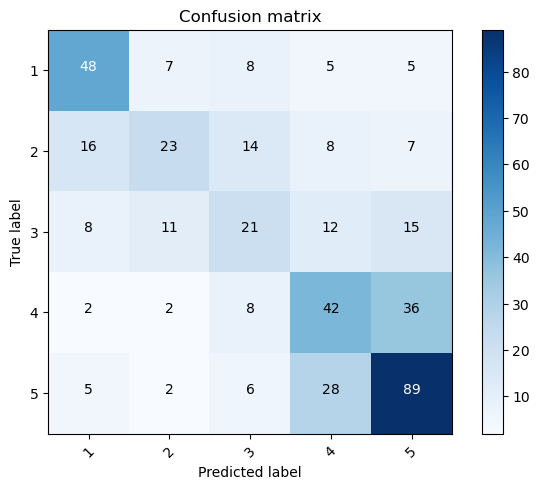

In [30]:
from sklearn import metrics

score = metrics.accuracy_score(df_test_model["class_index"], df_test_model["prediction"])
#score = metrics.accuracy_score(y_test, y_pred)
print("accuracy:   %0.3f" % score)

cm = metrics.confusion_matrix(df_test_model["class_index"], df_test_model["prediction"])
#cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=[1, 2, 3, 4, 5])

Probably more epochs needed for better results and/or improved model